In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
from insitupy.utils.geo import parse_geopandas
from insitupy.utils.io import read_json
import numpy as np
import shapely
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from insitupy import XeniumData
from rasterio.features import rasterize
from pathlib import Path

In [3]:
baysor_folder = Path(r"C:\Users\ge37voy\Downloads\tmp\baysor\baysor_output-0017321__N-436-21-N__20240219__131654")
annotfile = Path(r"C:\Users\ge37voy\Github\InSituPy\notebooks\demo_annotations\annotations-slide_id__sample_id__demo2.geojson")
xdfile = Path("C:/Users/ge37voy/Downloads/tmp/test/")

In [4]:
jsonfile = baysor_folder / "segmentation_polygons.geojson"
d = read_json(jsonfile)
xd = XeniumData(xdfile)

In [5]:
xd.read_all()

Reading annotations...
No `annotations` modality found.
Reading cells...
Reading images...


c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Reading regions...
No `regions` modality found.
Reading transcripts...


In [6]:
xd

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\Downloads\tmp
Data folder:	test
Metadata file:	.xeniumdata
    ➤ images
       nuclei:	(1682, 1646)
       HE:	(1682, 1646, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 1046 × 314
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ transcripts
       DataFrame with shape 189588 x 10

In [10]:
xd.images.nuclei

[dask.array<from-zarr, shape=(1682, 1646), dtype=uint16, chunksize=(1024, 1024), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(841, 823), dtype=uint16, chunksize=(841, 823), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(420, 411), dtype=uint16, chunksize=(420, 411), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(210, 205), dtype=uint16, chunksize=(210, 205), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(105, 102), dtype=uint16, chunksize=(105, 102), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(52, 51), dtype=uint16, chunksize=(52, 51), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(26, 25), dtype=uint16, chunksize=(26, 25), chunktype=numpy.ndarray>,
 dask.array<from-zarr, shape=(13, 12), dtype=uint16, chunksize=(13, 12), chunktype=numpy.ndarray>]

In [7]:
xd

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\Downloads\tmp
Data folder:	test
Metadata file:	.xeniumdata
    ➤ images
       nuclei:	(1682, 1646)
       HE:	(1682, 1646, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 1046 × 314
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ transcripts
       DataFrame with shape 189588 x 10

In [7]:
savefile = xdfile.parent / "savetest"

In [9]:
xd.show()

In [8]:
xd.cells.boundaries.cellular

,cell_id,vertex_x,vertex_y
4420,abbggcnl-1,200.757568,170.680420
4421,abbggcnl-1,197.995117,172.380615
4422,abbggcnl-1,198.632568,181.093018
4423,abbggcnl-1,202.457764,186.617920
4424,abbggcnl-1,205.857666,192.143066
...,...,...,...
594790,jedgdcjb-1,251.970215,10.030518
594791,jedgdcjb-1,251.757568,7.480469
594792,jedgdcjb-1,251.332764,5.992920
594793,jedgdcjb-1,247.720215,1.530518


In [11]:
df = {
    "geometry": [],
    "cell": [],
    "type": [],
    "minx": [],
    "miny": [],
    "maxx": [],
    "maxy": []
}
for elem in tqdm(d["geometries"]):
    coords = elem["coordinates"][0]
    
    # check if there are enough coordinates for a Polygon (some segmented cells are very small in Baysor)
    if len(coords) > 3:
        p = shapely.Polygon(coords)
        df["geometry"].append(p)
        df["type"].append("polygon")
    
    else:
        p = shapely.LineString(coords)
        df["geometry"].append(p)
        df["type"].append("line")
    df["cell"].append(elem["cell"])
    
    # extract bounding box
    bounds = p.bounds
    df["minx"].append(bounds[0])
    df["miny"].append(bounds[1])
    df["maxx"].append(bounds[2])
    df["maxy"].append(bounds[3])

# create geopandas dataframe
df = gpd.GeoDataFrame(df)

100%|██████████| 1573/1573 [00:00<00:00, 22125.03it/s]


In [12]:
df

,geometry,cell,type,minx,miny,maxx,maxy
0,"POLYGON ((339.712 298.611, 343.270 301.395, 34...",1144,polygon,339.711670,291.68335,349.920170,301.39478
1,"POLYGON ((243.906 279.677, 244.500 280.510, 24...",1175,polygon,242.445560,272.25464,252.548100,283.09814
2,"POLYGON ((269.550 126.755, 270.049 128.803, 27...",719,polygon,268.588130,120.41797,281.343750,131.38428
3,"POLYGON ((63.277 265.403, 64.307 265.742, 65.0...",1546,polygon,63.276610,262.75170,65.144775,265.74220
4,"POLYGON ((349.779 196.436, 349.666 195.989, 34...",1028,polygon,342.834960,195.98877,349.918950,205.03442
...,...,...,...,...,...,...,...
1568,"POLYGON ((199.492 309.354, 203.097 312.295, 20...",979,polygon,199.492430,304.48315,208.278320,313.10498
1569,"POLYGON ((9.806 115.050, 10.241 115.969, 11.57...",65,polygon,6.021729,112.27173,12.183105,117.64575
1570,"POLYGON ((69.446 187.078, 69.996 187.289, 70.9...",298,polygon,68.934326,183.23584,78.585940,191.91455
1571,"POLYGON ((338.980 320.151, 339.934 320.610, 34...",1402,polygon,338.926760,318.62744,341.620120,321.16138


In [13]:
df["geometry"]

0       POLYGON ((339.712 298.611, 343.270 301.395, 34...
1       POLYGON ((243.906 279.677, 244.500 280.510, 24...
2       POLYGON ((269.550 126.755, 270.049 128.803, 27...
3       POLYGON ((63.277 265.403, 64.307 265.742, 65.0...
4       POLYGON ((349.779 196.436, 349.666 195.989, 34...
                              ...                        
1568    POLYGON ((199.492 309.354, 203.097 312.295, 20...
1569    POLYGON ((9.806 115.050, 10.241 115.969, 11.57...
1570    POLYGON ((69.446 187.078, 69.996 187.289, 70.9...
1571    POLYGON ((338.980 320.151, 339.934 320.610, 34...
1572    POLYGON ((333.165 274.988, 333.725 275.140, 33...
Name: geometry, Length: 1573, dtype: geometry

In [14]:
xd

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\Downloads\tmp
Data folder:	test
Metadata file:	.xeniumdata
    ➤ images
       nuclei:	(1682, 1646)
       HE:	(1682, 1646, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 1046 × 314
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ transcripts
       DataFrame with shape 189588 x 10

In [15]:
xd.images

images
nuclei:	(1682, 1646)
HE:	(1682, 1646, 3)

In [16]:
xd

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\Downloads\tmp
Data folder:	test
Metadata file:	.xeniumdata
    ➤ images
       nuclei:	(1682, 1646)
       HE:	(1682, 1646, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 1046 × 314
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ transcripts
       DataFrame with shape 189588 x 10

In [17]:
xd.transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000
4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000
4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772708
4819416,281539401220598,bojgkfjl-1,1,PARP1,5.524170,5.807617,14.416108,40.000000,AD16,0.000000
4819417,281539401220601,bojpekmg-1,1,SH2B3,6.376221,37.215576,16.898867,40.000000,AD16,0.000000
...,...,...,...,...,...,...,...,...,...,...
6073158,281569466646810,inkfnhkf-1,0,CDH6,349.547119,295.708008,15.103813,35.667240,AE16,1.526855
6073159,281569466646811,inhabjpp-1,0,GUCY1A2,349.693604,227.955566,14.345278,40.000000,AE16,0.099854
6073160,281569466646812,ilficmgn-1,0,GUCY1A2,349.749756,314.770508,16.322037,40.000000,AE16,2.314134
6073161,281569466646814,iokapmjd-1,1,HDC,349.765869,198.994141,14.610005,39.342621,AE16,0.000000


In [18]:
from math import ceil


In [19]:
xmax = ceil(xd.cells.matrix.obsm['spatial'][:, 0].max() + 15)
ymax = ceil(xd.cells.matrix.obsm['spatial'][:, 1].max() + 15)

In [20]:
img = rasterize(list(zip(df["geometry"], range(1, len(df)+1))), out_shape=(ymax,xmax))

In [21]:
xd.transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000
4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000
4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772708
4819416,281539401220598,bojgkfjl-1,1,PARP1,5.524170,5.807617,14.416108,40.000000,AD16,0.000000
4819417,281539401220601,bojpekmg-1,1,SH2B3,6.376221,37.215576,16.898867,40.000000,AD16,0.000000
...,...,...,...,...,...,...,...,...,...,...
6073158,281569466646810,inkfnhkf-1,0,CDH6,349.547119,295.708008,15.103813,35.667240,AE16,1.526855
6073159,281569466646811,inhabjpp-1,0,GUCY1A2,349.693604,227.955566,14.345278,40.000000,AE16,0.099854
6073160,281569466646812,ilficmgn-1,0,GUCY1A2,349.749756,314.770508,16.322037,40.000000,AE16,2.314134
6073161,281569466646814,iokapmjd-1,1,HDC,349.765869,198.994141,14.610005,39.342621,AE16,0.000000


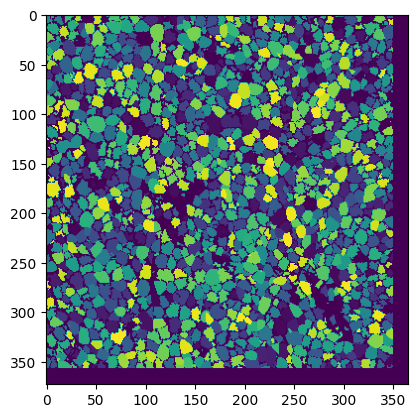

In [22]:
plt.imshow(img)

In [29]:
xd.show()

In [23]:
pixel_size = xd.metadata["pixel_size"]

In [31]:
xd.viewer.add_labels(img, name='cell_mask', scale=(1, 1))

<Labels layer 'cell_mask' at 0x255b563a2b0>

In [24]:
xd

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\Downloads\tmp
Data folder:	test
Metadata file:	.xeniumdata
    ➤ images
       nuclei:	(1682, 1646)
       HE:	(1682, 1646, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 1046 × 314
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ transcripts
       DataFrame with shape 189588 x 10

Cell 1570 is very small and only consists of two points. How is that possible?

In [25]:
# cell stats
cs_file = r"C:\Users\ge37voy\Downloads\tmp\baysor\baysor_output-0017321__N-436-21-N__20240219__131654\segmentation_cell_stats.csv"
pd.read_csv(cs_file)

,cell,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,max_cluster_frac,lifespan
0,CR1548b828b-1,6.678945,2.068309,16.642422,4,24,1.5710,1.327,15.280,0.9984,0.9817,1.000000,50
1,CR1548b828b-2,12.842599,5.376065,16.708813,1,102,1.0890,2.562,93.680,0.9886,0.8935,0.990196,50
2,CR1548b828b-3,3.035172,22.848029,16.470479,1,91,1.1750,1.846,77.440,0.9865,0.9237,1.000000,50
3,CR1548b828b-4,23.598982,3.279715,15.753729,1,35,0.6226,3.414,56.220,0.8552,0.9594,0.885714,50
4,CR1548b828b-5,7.282680,15.050926,16.281299,1,162,1.4110,2.296,114.800,0.9950,0.8952,0.993827,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568,CR1548b828b-1569,75.532472,7.444092,13.794286,1,2,NaN,NaN,NaN,0.9996,0.1200,1.000000,6
1569,CR1548b828b-1570,32.771730,209.639650,17.615406,1,1,NaN,NaN,NaN,0.9897,0.0800,1.000000,6
1570,CR1548b828b-1571,118.189330,89.144285,13.829876,1,2,NaN,NaN,NaN,0.9385,0.0700,1.000000,6
1571,CR1548b828b-1572,2.528076,125.980926,17.133464,1,8,1.4430,1.770,5.543,0.9857,0.0375,1.000000,3


In [26]:
segcsv_file = baysor_folder / "segmentation.csv"
segdf = pd.read_csv(segcsv_file)

In [27]:
segdf

,Unnamed: 0,transcript_id,cell_id,overlaps_nucleus,gene,x,y,z,qv,fov_name,nucleus_distance,cell_id_renamed,molecule_id,prior_segmentation,confidence,cluster,cell,assignment_confidence,is_noise,ncv_color
0,4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000,0,1,0,0.99998,1,CR1548b828b-1386,0.86,False,#009784
1,4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000,1,2,1,0.99999,1,CR1548b828b-3,1.00,False,#484E1F
2,4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772707,1,3,1,0.99947,1,CR1548b828b-5,0.52,False,#007CFF
3,4819416,281539401220598,bojgkfjl-1,1,PARP1,5.524170,5.807617,14.416108,40.000000,AD16,0.000000,0,4,0,0.99992,1,CR1548b828b-1386,0.68,False,#007E5D
4,4819417,281539401220601,bojpekmg-1,1,SH2B3,6.376221,37.215576,16.898867,40.000000,AD16,0.000000,2,5,2,0.99998,1,CR1548b828b-7,0.42,False,#005A81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161411,6073158,281569466646810,inkfnhkf-1,0,CDH6,349.547120,295.708000,15.103813,35.667240,AE16,1.526855,953,161412,953,0.99979,1,CR1548b828b-1144,1.00,False,#007AC9
161412,6073159,281569466646811,inhabjpp-1,0,GUCY1A2,349.693600,227.955570,14.345278,40.000000,AE16,0.099854,1064,161413,1064,0.99616,1,CR1548b828b-1309,0.92,False,#494409
161413,6073160,281569466646812,ilficmgn-1,0,GUCY1A2,349.749760,314.770500,16.322037,40.000000,AE16,2.314134,1054,161414,1054,0.99994,1,CR1548b828b-1156,0.88,False,#005F88
161414,6073161,281569466646814,iokapmjd-1,1,HDC,349.765870,198.994140,14.610005,39.342620,AE16,0.000000,955,161415,955,0.99993,1,CR1548b828b-1028,0.98,False,#008291


In [28]:
trans = xd.transcripts

In [76]:
trans

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000
4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000
4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772708
4819416,281539401220598,bojgkfjl-1,1,PARP1,5.524170,5.807617,14.416108,40.000000,AD16,0.000000
4819417,281539401220601,bojpekmg-1,1,SH2B3,6.376221,37.215576,16.898867,40.000000,AD16,0.000000
...,...,...,...,...,...,...,...,...,...,...
6073158,281569466646810,inkfnhkf-1,0,CDH6,349.547119,295.708008,15.103813,35.667240,AE16,1.526855
6073159,281569466646811,inhabjpp-1,0,GUCY1A2,349.693604,227.955566,14.345278,40.000000,AE16,0.099854
6073160,281569466646812,ilficmgn-1,0,GUCY1A2,349.749756,314.770508,16.322037,40.000000,AE16,2.314134
6073161,281569466646814,iokapmjd-1,1,HDC,349.765869,198.994141,14.610005,39.342621,AE16,0.000000


In [29]:
trans["cell_id"].to_xarray()

<xarray.DataArray 'cell_id' (index: 189588)>
array(['bojgkfjl-1', 'bojfmjbo-1', 'bojfmjbo-1', ..., 'ilficmgn-1',
       'iokapmjd-1', 'jafmfcio-1'], dtype=object)
Coordinates:
  * index    (index) int64 4819400 4819403 4819404 ... 6073160 6073161 6073162

In [30]:
import xarray as xr

In [31]:
xr.Dataset(
    data_vars=dict(
        default = segdf.cell_id.values,
        baysor = segdf.cell.values
    ),
    coords=dict(
        x = segdf.x.values,
        y = segdf.y.values,
        z = segdf.z.values
    )
)

<xarray.Dataset>
Dimensions:  (default: 161416, baysor: 161416, x: 161416, y: 161416, z: 161416)
Coordinates:
  * default  (default) object 'bojgkfjl-1' 'bojfmjbo-1' ... 'jafmfcio-1'
  * baysor   (baysor) object 'CR1548b828b-1386' ... 'CR1548b828b-910'
  * x        (x) float64 1.221 1.845 2.298 5.524 ... 349.7 349.7 349.8 349.7
  * y        (y) float64 5.587 22.26 16.82 5.808 ... 228.0 314.8 199.0 136.5
  * z        (z) float64 17.08 18.74 14.08 14.42 ... 14.35 16.32 14.61 17.21
Data variables:
    *empty*

In [74]:
segdf.is_noise.sum()

397

In [75]:
segdf

,Unnamed: 0,transcript_id,cell_id,overlaps_nucleus,gene,x,y,z,qv,fov_name,nucleus_distance,cell_id_renamed,molecule_id,prior_segmentation,confidence,cluster,cell,assignment_confidence,is_noise,ncv_color
0,4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000,0,1,0,0.99998,1,CR1548b828b-1386,0.86,False,#009784
1,4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000,1,2,1,0.99999,1,CR1548b828b-3,1.00,False,#484E1F
2,4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772707,1,3,1,0.99947,1,CR1548b828b-5,0.52,False,#007CFF
3,4819416,281539401220598,bojgkfjl-1,1,PARP1,5.524170,5.807617,14.416108,40.000000,AD16,0.000000,0,4,0,0.99992,1,CR1548b828b-1386,0.68,False,#007E5D
4,4819417,281539401220601,bojpekmg-1,1,SH2B3,6.376221,37.215576,16.898867,40.000000,AD16,0.000000,2,5,2,0.99998,1,CR1548b828b-7,0.42,False,#005A81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161411,6073158,281569466646810,inkfnhkf-1,0,CDH6,349.547120,295.708000,15.103813,35.667240,AE16,1.526855,953,161412,953,0.99979,1,CR1548b828b-1144,1.00,False,#007AC9
161412,6073159,281569466646811,inhabjpp-1,0,GUCY1A2,349.693600,227.955570,14.345278,40.000000,AE16,0.099854,1064,161413,1064,0.99616,1,CR1548b828b-1309,0.92,False,#494409
161413,6073160,281569466646812,ilficmgn-1,0,GUCY1A2,349.749760,314.770500,16.322037,40.000000,AE16,2.314134,1054,161414,1054,0.99994,1,CR1548b828b-1156,0.88,False,#005F88
161414,6073161,281569466646814,iokapmjd-1,1,HDC,349.765870,198.994140,14.610005,39.342620,AE16,0.000000,955,161415,955,0.99993,1,CR1548b828b-1028,0.98,False,#008291


In [38]:
segdf.head(3)

,Unnamed: 0,transcript_id,cell_id,overlaps_nucleus,gene,x,y,z,qv,fov_name,nucleus_distance,cell_id_renamed,molecule_id,prior_segmentation,confidence,cluster,cell,assignment_confidence,is_noise,ncv_color
0,4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000,0,1,0,0.99998,1,CR1548b828b-1386,0.86,False,#009784
1,4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000,1,2,1,0.99999,1,CR1548b828b-3,1.00,False,#484E1F
2,4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772707,1,3,1,0.99947,1,CR1548b828b-5,0.52,False,#007CFF


In [39]:
trans.head(3)

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000
4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000
4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772708


In [49]:
ds = xr.Dataset(
    data_vars=dict(
        default = (["transcripts"], segdf.cell_id.values),
        baysor = (["transcripts"], segdf.cell.values)
    ),
    coords=dict(
        x = ("transcripts", segdf.x.values),
        y = ("transcripts", segdf.y.values),
        z = ("transcripts", segdf.z.values),
        gene = ("transcripts", segdf.gene.values)
    ),
)

In [50]:
ds

<xarray.Dataset>
Dimensions:  (transcripts: 161416)
Coordinates:
    x        (transcripts) float64 1.221 1.845 2.298 5.524 ... 349.7 349.8 349.7
    y        (transcripts) float64 5.587 22.26 16.82 5.808 ... 314.8 199.0 136.5
    z        (transcripts) float64 17.08 18.74 14.08 14.42 ... 16.32 14.61 17.21
    gene     (transcripts) object 'KLRK1' 'PARP1' 'TIMP1' ... 'HDC' 'HDC'
Dimensions without coordinates: transcripts
Data variables:
    default  (transcripts) object 'bojgkfjl-1' 'bojfmjbo-1' ... 'jafmfcio-1'
    baysor   (transcripts) object 'CR1548b828b-1386' ... 'CR1548b828b-910'

In [57]:
mask = (ds.x < 2) & (ds.y < 100) & (ds.z < 200)

In [59]:
mask

<xarray.DataArray (transcripts: 161416)>
array([ True,  True, False, ..., False, False, False])
Coordinates:
    x        (transcripts) float64 1.221 1.845 2.298 5.524 ... 349.7 349.8 349.7
    y        (transcripts) float64 5.587 22.26 16.82 5.808 ... 314.8 199.0 136.5
    z        (transcripts) float64 17.08 18.74 14.08 14.42 ... 16.32 14.61 17.21
    gene     (transcripts) object 'KLRK1' 'PARP1' 'TIMP1' ... 'HDC' 'HDC'
Dimensions without coordinates: transcripts

In [66]:
ds.where(ds.x > 100).default

<xarray.DataArray 'default' (transcripts: 161416)>
array([nan, nan, nan, ..., 'ilficmgn-1', 'iokapmjd-1', 'jafmfcio-1'],
      dtype=object)
Coordinates:
    x        (transcripts) float64 1.221 1.845 2.298 5.524 ... 349.7 349.8 349.7
    y        (transcripts) float64 5.587 22.26 16.82 5.808 ... 314.8 199.0 136.5
    z        (transcripts) float64 17.08 18.74 14.08 14.42 ... 16.32 14.61 17.21
    gene     (transcripts) object 'KLRK1' 'PARP1' 'TIMP1' ... 'HDC' 'HDC'
Dimensions without coordinates: transcripts

In [68]:
xd.cells

matrix
    AnnData object with n_obs × n_vars = 1046 × 314
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
boundaries
    BoundariesData object with 2 entries:
        cellular
        nuclear

In [70]:
xd.transcripts

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance
4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000
4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000
4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772708
4819416,281539401220598,bojgkfjl-1,1,PARP1,5.524170,5.807617,14.416108,40.000000,AD16,0.000000
4819417,281539401220601,bojpekmg-1,1,SH2B3,6.376221,37.215576,16.898867,40.000000,AD16,0.000000
...,...,...,...,...,...,...,...,...,...,...
6073158,281569466646810,inkfnhkf-1,0,CDH6,349.547119,295.708008,15.103813,35.667240,AE16,1.526855
6073159,281569466646811,inhabjpp-1,0,GUCY1A2,349.693604,227.955566,14.345278,40.000000,AE16,0.099854
6073160,281569466646812,ilficmgn-1,0,GUCY1A2,349.749756,314.770508,16.322037,40.000000,AE16,2.314134
6073161,281569466646814,iokapmjd-1,1,HDC,349.765869,198.994141,14.610005,39.342621,AE16,0.000000


In [71]:
segdf

,Unnamed: 0,transcript_id,cell_id,overlaps_nucleus,gene,x,y,z,qv,fov_name,nucleus_distance,cell_id_renamed,molecule_id,prior_segmentation,confidence,cluster,cell,assignment_confidence,is_noise,ncv_color
0,4819400,281539401220556,bojgkfjl-1,1,KLRK1,1.221191,5.587158,17.079643,40.000000,AD16,0.000000,0,1,0,0.99998,1,CR1548b828b-1386,0.86,False,#009784
1,4819403,281539401220560,bojfmjbo-1,1,PARP1,1.844727,22.256836,18.742792,25.045572,AD16,0.000000,1,2,1,0.99999,1,CR1548b828b-3,1.00,False,#484E1F
2,4819404,281539401220565,bojfmjbo-1,0,TIMP1,2.298096,16.815430,14.080606,40.000000,AD16,0.772707,1,3,1,0.99947,1,CR1548b828b-5,0.52,False,#007CFF
3,4819416,281539401220598,bojgkfjl-1,1,PARP1,5.524170,5.807617,14.416108,40.000000,AD16,0.000000,0,4,0,0.99992,1,CR1548b828b-1386,0.68,False,#007E5D
4,4819417,281539401220601,bojpekmg-1,1,SH2B3,6.376221,37.215576,16.898867,40.000000,AD16,0.000000,2,5,2,0.99998,1,CR1548b828b-7,0.42,False,#005A81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161411,6073158,281569466646810,inkfnhkf-1,0,CDH6,349.547120,295.708000,15.103813,35.667240,AE16,1.526855,953,161412,953,0.99979,1,CR1548b828b-1144,1.00,False,#007AC9
161412,6073159,281569466646811,inhabjpp-1,0,GUCY1A2,349.693600,227.955570,14.345278,40.000000,AE16,0.099854,1064,161413,1064,0.99616,1,CR1548b828b-1309,0.92,False,#494409
161413,6073160,281569466646812,ilficmgn-1,0,GUCY1A2,349.749760,314.770500,16.322037,40.000000,AE16,2.314134,1054,161414,1054,0.99994,1,CR1548b828b-1156,0.88,False,#005F88
161414,6073161,281569466646814,iokapmjd-1,1,HDC,349.765870,198.994140,14.610005,39.342620,AE16,0.000000,955,161415,955,0.99993,1,CR1548b828b-1028,0.98,False,#008291


In [67]:
ds.where(ds.x > 300, drop=True)

<xarray.Dataset>
Dimensions:  (transcripts: 24235)
Coordinates:
    x        (transcripts) float64 304.6 307.9 308.6 312.6 ... 349.7 349.8 349.7
    y        (transcripts) float64 26.11 12.23 21.09 7.406 ... 314.8 199.0 136.5
    z        (transcripts) float64 17.72 15.56 12.92 16.31 ... 16.32 14.61 17.21
    gene     (transcripts) object 'PARP1' 'PARP1' 'PARP1' ... 'HDC' 'HDC'
Dimensions without coordinates: transcripts
Data variables:
    default  (transcripts) object 'jcheeagj-1' 'jdjdcpio-1' ... 'jafmfcio-1'
    baysor   (transcripts) object 'CR1548b828b-1172' ... 'CR1548b828b-910'

In [58]:
ds[mask]

ValueError: Unsupported key-type <class 'xarray.core.dataarray.DataArray'>

In [46]:
ds.dims

Frozen({'transcripts': 161416})

In [48]:
ds.loc(10)

TypeError: '_LocIndexer' object is not callable

In [43]:
ds.indexes["test"] = segdf.transcript_id.values

TypeError: 'Indexes' object does not support item assignment

In [54]:
xr.Dataset(
    data_vars=dict(
        default = segdf[["cell_id", "assignment_confidence"]].values,
        baysor = segdf[["cell", "assignment_confidence"]].values
    ),
    coords=dict(
        x = ("coord", segdf.x.values),
        y = segdf.y.values,
        z = segdf.z.values,
        gene = segdf.gene.values
    )
)

MissingDimensionsError: cannot set variable 'default' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

array([[  1.2211914,   5.587158 ,  17.079643 ],
       [  1.8447266,  22.256836 ,  18.742792 ],
       [  2.2980957,  16.81543  ,  14.0806055],
       ...,
       [349.74976  , 314.7705   ,  16.322037 ],
       [349.76587  , 198.99414  ,  14.610005 ],
       [349.74927  , 136.54663  ,  17.210468 ]])

In [47]:
xr.Dataset(
    data_vars=dict(
        default = segdf.cell_id.values,
        baysor = segdf.cell.values
    ),
    coords=dict(
        position = (["x", "y", "z"], segdf[["x", "y", "z"]].values)
    )
)

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['x', 'y', 'z'], array([[  1.2211914,   5.587158 ,  17.079643 ],
       [  1.8447266,  22.256836 ,  18.742792 ],
       [  2.2980957,  16.81543  ,  14.0806055],
       ...,
       [349.74976  , 314.7705   ,  16.322037 ],
       [349.76587  , 198.99414  ,  14.610005 ],
       [349.74927  , 136.54663  ,  17.210468 ]])) to Variable.

In [ ]:
xr.Dataset(
    data_vars=dict(
        default = segdf.cell_id.values,
        baysor = segdf.cell.values
    ),
    coords=dict(
        x = segdf.x.values,
        y = segdf.y.values,
        z = segdf.z.values
    )
)

<xarray.Dataset>
Dimensions:  (default: 161416, baysor: 161416, x: 161416, y: 161416, z: 161416)
Coordinates:
  * default  (default) object 'bojgkfjl-1' 'bojfmjbo-1' ... 'jafmfcio-1'
  * baysor   (baysor) object 'CR1548b828b-1386' ... 'CR1548b828b-910'
  * x        (x) float64 1.221 1.845 2.298 5.524 ... 349.7 349.7 349.8 349.7
  * y        (y) float64 5.587 22.26 16.82 5.808 ... 228.0 314.8 199.0 136.5
  * z        (z) float64 17.08 18.74 14.08 14.42 ... 14.35 16.32 14.61 17.21
Data variables:
    *empty*

In [ ]:
xdf

<xarray.Dataset>
Dimensions:   (index: 1573)
Coordinates:
  * index     (index) int64 0 1 2 3 4 5 6 ... 1566 1567 1568 1569 1570 1571 1572
Data variables:
    geometry  (index) object POLYGON ((339.71167 298.6106, 343.26978 301.3947...
    cell      (index) int64 1144 1175 719 1546 1028 699 ... 979 65 298 1402 1115
    type      (index) object 'polygon' 'polygon' ... 'polygon' 'polygon'
    minx      (index) float64 339.7 242.4 268.6 63.28 ... 68.93 338.9 332.1
    miny      (index) float64 291.7 272.3 120.4 262.8 ... 183.2 318.6 268.5
    maxx      (index) float64 349.9 252.5 281.3 65.14 ... 78.59 341.6 339.5
    maxy      (index) float64 301.4 283.1 131.4 265.7 ... 191.9 321.2 275.1

In [14]:
import scanpy as sc

In [15]:
loomfile = r"C:\Users\ge37voy\Downloads\tmp\baysor\baysor_output-0017321__N-436-21-N__20240219__131654\segmentation_counts.loom"
adata = sc.read_loom(loomfile)

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
xd.cells.matrix

AnnData object with n_obs × n_vars = 1046 × 314
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

In [19]:
xd.cells.boundaries.cellular

,cell_id,vertex_x,vertex_y
4420,abbggcnl-1,200.757568,170.680420
4421,abbggcnl-1,197.995117,172.380615
4422,abbggcnl-1,198.632568,181.093018
4423,abbggcnl-1,202.457764,186.617920
4424,abbggcnl-1,205.857666,192.143066
...,...,...,...
594790,jedgdcjb-1,251.970215,10.030518
594791,jedgdcjb-1,251.757568,7.480469
594792,jedgdcjb-1,251.332764,5.992920
594793,jedgdcjb-1,247.720215,1.530518


In [17]:
adata

AnnData object with n_obs × n_vars = 1573 × 320
    obs: 'Name', 'area', 'avg_assignment_confidence', 'avg_confidence', 'cluster', 'density', 'elongation', 'lifespan', 'max_cluster_frac', 'n_transcripts', 'x', 'y', 'z'
    var: 'Name'

In [ ]:
adata.obs

,Name,area,avg_assignment_confidence,avg_confidence,cluster,density,elongation,lifespan,max_cluster_frac,n_transcripts,x,y,z
CellID,,,,,,,,,,,,,
1.0,CR1548b828b-1,15.280,0.9817,0.9984,4,1.5710,1.327,50,1.000000,24,6.678945,2.068309,16.642422
2.0,CR1548b828b-2,93.680,0.8935,0.9886,1,1.0890,2.562,50,0.990196,102,12.842599,5.376065,16.708813
3.0,CR1548b828b-3,77.440,0.9237,0.9865,1,1.1750,1.846,50,1.000000,91,3.035172,22.848029,16.470479
4.0,CR1548b828b-4,56.220,0.9594,0.8552,1,0.6226,3.414,50,0.885714,35,23.598982,3.279715,15.753729
5.0,CR1548b828b-5,114.800,0.8952,0.9950,1,1.4110,2.296,50,0.993827,162,7.282680,15.050926,16.281299
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569.0,CR1548b828b-1569,NaN,0.1200,0.9996,1,NaN,NaN,6,1.000000,2,75.532472,7.444092,13.794286
1570.0,CR1548b828b-1570,NaN,0.0800,0.9897,1,NaN,NaN,6,1.000000,1,32.771730,209.639650,17.615406
1571.0,CR1548b828b-1571,NaN,0.0700,0.9385,1,NaN,NaN,6,1.000000,2,118.189330,89.144285,13.829876
